# File Description

This notebook contains the most contains the latest version of the time dependent BN modeling for Tarawa, Kiribati.

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime, time, timedelta
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from folium.plugins import FloatImage as FloatImage
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython

from BNModel import BNModel

from preprocessing_all_points import *
from preprocessing_points_spatially_temporally import *
from compile_model_t import *

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [3]:
# ### set location of file storage
# folder = 'BN_antonio_data'
# try:
#     os.makedirs(folder)
# except FileExistsError:
#     pass

# Data Prep

## Preprocessing

In [4]:
# Import and preprocess data
df_lagoon_profiles,df_ocean_profiles,inundation_dict,winds_dict,waves_dict,tide_dict,sla_dict,time_dict = \
    loading_tarawa_data()

In [5]:
df_lagoon_profiles

,shore_long,shore_lat,reef_long,reef_lat,reef_depth
0,172.92263,1.358684,172.92347,1.371918,0.001992
1,172.92618,1.358266,172.92681,1.370244,0.001485
2,172.92947,1.359989,172.93025,1.369275,0.002768
3,172.93370,1.362857,172.93518,1.368130,0.002831
4,173.11908,1.395376,173.10822,1.391547,0.000576
...,...,...,...,...,...
140,172.96607,1.598569,172.95633,1.594290,0.001792
141,172.96359,1.603089,172.95606,1.596228,0.002677
142,172.96076,1.606479,172.95465,1.597109,0.002759
143,172.95703,1.608513,172.95254,1.598607,0.001439


In [6]:
df_ocean_profiles

,shore_long,shore_lat,reef_long,reef_lat,reef_width,reef_depth,forereef_slope,m,shore_dir
0,172.92001,1.359241,172.90162,1.380442,1815.70350,2.532653,0.018279,-1.152871,319.061643
1,172.91848,1.356421,172.89642,1.357271,389.26039,0.762624,0.004784,-0.038531,272.206588
2,172.92019,1.353139,172.91862,1.342910,639.97829,1.268571,0.088677,6.514968,188.726378
3,172.92488,1.353647,172.92461,1.342294,673.60616,1.124577,0.075739,42.051111,181.362270
4,172.92935,1.353986,172.92990,1.342910,685.94954,1.055773,0.088621,-20.138000,177.157178
...,...,...,...,...,...,...,...,...,...
177,172.91907,1.357814,172.89827,1.369253,521.44384,1.481050,0.005864,-0.549976,298.809736
178,172.91862,1.354158,172.90065,1.346258,1516.82890,1.841662,0.027996,0.439622,246.268673
179,172.95727,1.636152,172.95393,1.645588,618.70990,1.091268,0.060486,-2.824940,340.506556
180,173.04626,1.356990,173.04952,1.348703,525.15634,1.362362,0.086555,-2.542086,158.526428


In [7]:
time_min = datetime(2015,2,15)
time_step = timedelta(hours=24)
max_steps = 50

times_for_model = []

for step in np.arange(0,max_steps,1):
    time_at_step = time_min+time_step*step
    
    times_for_model.append(time_at_step)
    

## Create Variable Dictionary

In [8]:
def initialise_model_dictionaries():
    #### Don't include spaces in bin names. if no discretisation, just leave out that key
    lagoon_model_dict = {
        'variables':{
            'wind_u':{
                'label':'Wind u vector (m/s)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'wind_v':{
                'label':r'Wind v vector (m/s)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'uniform',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'Hs_offshore':{
                'label':'Offshore wave height (m)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','HighMid','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'Tm_offshore':{
                'label':'Offshore wave period (s)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'Dir_offshore':{
                'label':r'Offshore wave direction (degrees)',
                'discretisation':{
                    'n_bins':8,
                    'strategy':'kmeans',
                    'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
                },
                'child_nodes':['WL_wave_comp']
            },
            'WL_wave_comp':{
                'label':'Water level from wave component (m)',
                'discretisation':{
                    'n_bins':7,
                    'strategy':'binned',
                    'bin_names':['VeryLow','Low','LowMid','Mid','MidHigh','High','VeryHigh'],
                    'bin_edges':np.arange(0,0.9,(0.9-0)/6)
                },
                'child_nodes':[]
            }
        },
        'training_frac':0.8,
        'bootstrap_reps':1
    }
    ocean_model_dict = {
       'variables':{
           'Tm_offshore':{
                'label':'Wave period offshore (?)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'Hs_offshore':{
                'label':'Wave height offshore (m)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'Dir_offshore':{
                'label':'Wave direction offshore (degrees)',
                'discretisation':{
                    'n_bins':8,
                    'strategy':'kmeans',
                    'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
                },
                'child_nodes':['WL_wave_comp']
            },
            'WL_wave_comp':{
                'label':'Water level from wave component (m)',
                'discretisation':{
                    'n_bins':7,
                    'strategy':'binned',
                    'bin_names':['VeryLow','Low','LowMid','Mid','MidHigh','High','VeryHigh'],
                    'bin_edges':np.arange(0.13,1.2,(1.2-.13)/6)
                },
                'child_nodes':[]
            },
            'reef_width':{
                'label':'Reef width (m)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'reef_depth':{
                'label':'Reef depth (m)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'forereef_slope':{
                'label':'Fore reef slope (degrees)',
                'discretisation':{
                    'n_bins':5,
                    'strategy':'kmeans',
                    'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
                },
                'child_nodes':['WL_wave_comp']
            },
            'shore_dir':{
                'label':'Shoreline direction (degrees)',
                'discretisation':{
                    'n_bins':3,
                    'strategy':'kmeans',
                    'bin_names':['NE','S','NW']
                },
                'child_nodes':['WL_wave_comp']
            }
       },
        'training_frac':0.8,
        'bootstrap_reps':1
    }
    return(lagoon_model_dict,ocean_model_dict)

In [9]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

def model_location(model_dict,location_details,evidence_dict,variable_list):
    
    '''
    function for adding the location information for one side model to the evidence dictionary
    '''
    
    for variable in variable_list:

        bin_edges = model_dict['variables'][variable]['bin_edges'][0]
        value = location_details[variable]

        var_bin = bin_locator(value,bin_edges)
        
        evidence_array = [0]*(len(bin_edges)-1)
        evidence_array[var_bin] = 1
        
        evidence_dict.update({
            variable:evidence_array
        })

    # Add evidence to model dict
    model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)
    
    # Set evidence and get beliefs
    model_location_dict = BNModel().update_evidence(model_location_dict)
    
    return(model_location_dict)

def location_probabilities(evidence_dict,model_dict,variable_list,df_profiles):
    '''
    
    Function for setting evidence and determing probabilties for twl at each point around the island based 
    on the reef characteristics at each location
    
    '''
    
    location_probabilities_dict = {}
    
    for index,row in df_profiles.iterrows():

        model_location_dict = model_location(model_dict,row,evidence_dict,variable_list)
        location_probabilities = model_location_dict['variables']['TWL']['resulting_probs'][0]

        df_location_probabilities = pd.DataFrame.from_dict(location_probabilities,orient='index')
        
        largest_cat = df_location_probabilities.idxmax()[0]

        location_probabilities_dict.update({
            (row.reef_long,row.reef_lat):\
                model_dict['variables']['TWL']['discretisation']['bin_names'].index(largest_cat)
        })
        
    return(location_probabilities_dict)

def add_time_lag(df,location_vars_list,time_delay_vars):
    previous_time_dict = {}

    for loc_vars,group in df.groupby(location_vars_list):
        df_orig = group.reset_index(drop=True)
        df_delay = group[time_delay_vars].iloc[:-1].reset_index(drop=True)
        df_delay.index = [x+1 for x in list(df_delay.index)]
        df_delay.drop('time',axis=1,inplace=True)
        group = df_orig.join(df_delay,rsuffix='_t_1',how='inner')

        previous_time_dict.update({
            loc_vars:group
        })

    df = pd.concat(previous_time_dict)
    
    return(df)

## Bootstrapping the data

# One network per time step

In [10]:
model_dicts_through_time_dict = {}
lagoon_probabilities_dict = {}
ocean_probabilities_dict = {}
    
for time_min,time_max in zip(times_for_model[:-2],times_for_model[2:]):
    lower_idx = np.abs([x-time_min for x in inundation_dict['Time']]).argmin()
    upper_idx = np.abs([x-time_max for x in inundation_dict['Time']]).argmin()
       
    inundation_time_slice_dict = {var:inundation_dict[var][lower_idx:upper_idx,:] for var in ['TWL','Tide']}
    inundation_time_slice_dict['Time'] = inundation_dict['Time'][lower_idx:upper_idx]
    inundation_time_slice_dict['Ptos'] = inundation_dict['Ptos']
    winds_time_slice_dict = {
        'wind_u':winds_dict['wind_u'][lower_idx:upper_idx],'wind_v':winds_dict['wind_v'][lower_idx:upper_idx]}
    waves_time_slice_dict = {var:waves_dict[var][lower_idx:upper_idx,:] for var in ['Diro','Hso','Tmo','Tpo']}
    waves_time_slice_dict['Timeo'] = waves_dict['Timeo'][lower_idx:upper_idx]
    
    tide_time_slice_dict = {'Tide':tide_dict['Tide'][lower_idx:upper_idx]}
    sla_time_slice_dict = {'MSL':sla_dict['MSL'][lower_idx:upper_idx]}
    time_slice_dict = {'time':time_dict['time'][lower_idx:upper_idx]}
    
    # list of variable that are predicted and included in lag
    predicted_lag_variables = []
    
    # Initialise model dicts
    lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()

    df_ocean,df_lagoon = \
        preprocessing_points_spatially_temporally(df_lagoon_profiles,
                                                  df_ocean_profiles,
                                                  inundation_time_slice_dict,
                                                  winds_time_slice_dict,
                                                  waves_time_slice_dict,
                                                  tide_time_slice_dict,
                                                  sla_time_slice_dict,
                                                  time_slice_dict,
                                                  predicted_lag_variables)
    
    # Define which variables are to be time lagged
    ocean_time_delay_vars = ['time','WL_wave_comp']
    lagoon_time_delay_vars = ['time','WL_wave_comp','wind_u','wind_v','Dir_offshore','Hs_offshore','Tm_offshore']

    # Because the lag is going to depend on the location, define the list of variables which are used to group by loc
    location_vars_list = ['lat','long']

    # Add the time lag variables
    df_ocean_with_lag = add_time_lag(df_ocean,location_vars_list,ocean_time_delay_vars)
    df_lagoon_with_lag = add_time_lag(df_lagoon,location_vars_list,lagoon_time_delay_vars)

    # Create dictionary of variables
    lagoon_data_dict = {column:np.array(df_lagoon_with_lag[column]) for column in df_lagoon_with_lag.columns}
    ocean_data_dict = {column:np.array(df_ocean_with_lag[column]) for column in df_ocean_with_lag.columns}

    # Remove the variables that I don't want to include in the model
    lagoon_data_dict = {key:item for key,item in lagoon_data_dict.items() if key not in ['lat','long','time','TWL','Tide','MSL']}
    ocean_data_dict = {key:item for key,item in ocean_data_dict.items() if key not in ['lat','long','time','wind_u','wind_v','TWL','Tide','MSL']}

    # Duplicate the variables to make T-1 in the model dictionary
    for var in ocean_time_delay_vars:
        if var!='time':
            ocean_model_dict['variables'][var+'_t_1'] = ocean_model_dict['variables'][var].copy()
            ocean_model_dict['variables'][var+'_t_1'].update({
                'child_nodes':[var]
            })
    for var in lagoon_time_delay_vars:
        if var!='time':
            lagoon_model_dict['variables'][var+'_t_1'] = lagoon_model_dict['variables'][var].copy()
            lagoon_model_dict['variables'][var+'_t_1'].update({
                'child_nodes':[var]
            })
    
    # remove lat long as indices
    df_ocean_with_lag = df_ocean_with_lag.reset_index(drop=True)
    df_lagoon_with_lag = df_lagoon_with_lag.reset_index(drop=True)
    
    lagoon_model_dict,ocean_model_dict = create_BN_time_t(lagoon_model_dict,
                                                          lagoon_data_dict,
                                                          df_lagoon_with_lag,
                                                          ocean_model_dict,
                                                          df_ocean_with_lag,
                                                          ocean_data_dict)    
    
    variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']

    # Create an empty location probability dictionary if this is the first timestep
    location_probabilities_dict = {}

    # Loop over each location, and create dictionary of each of the reef characteristics
    for index,row in df_ocean_profiles.iterrows():

        evidence_dict = {}

        for variable in variable_list:

            bin_edges = ocean_model_dict['variables'][variable]['bin_edges'][0]
            value = row[variable]

            var_bin = bin_locator(value,bin_edges)

            evidence_array = [0]*(len(bin_edges)-1)
            evidence_array[var_bin] = 1

            evidence_dict.update({
                variable:evidence_array
            })

        # Add evidence to model dict
        ocean_model_location_dict = BNModel().add_evidence_to_dict(ocean_model_dict,evidence_dict)

        # Set evidence and get beliefs
        ocean_model_dict = BNModel().update_evidence(ocean_model_dict
                                                    )
        # get location probs and put into a dict
        location_probabilities = ocean_model_location_dict['variables']['WL_wave_comp']['resulting_probs'][0]
        ocean_probabilities_dict.update({
            (time_min,row.reef_long,row.reef_lat):[x for y,x in location_probabilities.items()]
        })

    variable_list = []

    # Create an empty location probability dictionary if this is the first timestep
    location_probabilities_dict = {}

    # Loop over each location, and create dictionary of each of the reef characteristics
    for index,row in df_lagoon_profiles.iterrows():

        evidence_dict = {}

        for variable in variable_list:

            bin_edges = lagoon_model_dict['variables'][variable]['bin_edges'][0]
            value = row[variable]

            var_bin = bin_locator(value,bin_edges)

            evidence_array = [0]*(len(bin_edges)-1)
            evidence_array[var_bin] = 1

            evidence_dict.update({
                variable:evidence_array
            })

        # Add evidence to model dict
        lagoon_model_location_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,evidence_dict)

        # Set evidence and get beliefs
        lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict
                                                    )
        # get location probs and put into a dict
        location_probabilities = lagoon_model_location_dict['variables']['WL_wave_comp']['resulting_probs'][0]
        lagoon_probabilities_dict.update({
            (time_min,row.reef_long,row.reef_lat):[x for y,x in location_probabilities.items()]
        })
    
    print(time_min)
    

models created
2015-02-15 00:00:00
models created
2015-02-16 00:00:00
models created
2015-02-17 00:00:00
models created
2015-02-18 00:00:00
models created
2015-02-19 00:00:00
models created
2015-02-20 00:00:00
models created
2015-02-21 00:00:00
models created
2015-02-22 00:00:00
models created
2015-02-23 00:00:00
models created
2015-02-24 00:00:00
models created
2015-02-25 00:00:00
models created
2015-02-26 00:00:00
models created
2015-02-27 00:00:00
models created
2015-02-28 00:00:00
models created
2015-03-01 00:00:00
models created
2015-03-02 00:00:00
models created
2015-03-03 00:00:00
models created
2015-03-04 00:00:00
models created
2015-03-05 00:00:00
models created
2015-03-06 00:00:00
models created
2015-03-07 00:00:00
models created
2015-03-08 00:00:00
models created
2015-03-09 00:00:00
models created
2015-03-10 00:00:00
models created
2015-03-11 00:00:00
models created
2015-03-12 00:00:00
models created
2015-03-13 00:00:00
models created
2015-03-14 00:00:00
models created
2015-

In [11]:
pd.DataFrame.from_dict(ocean_probabilities_dict,orient='index')

,0,1,2,3,4,5,6
"(2015-02-15 00:00:00, 172.90162, 1.3804422)",0.143057,0.142824,0.142824,0.142824,0.142824,0.142824,0.142824
"(2015-02-15 00:00:00, 172.89642, 1.3572711)",0.142817,0.143604,0.142716,0.142716,0.142716,0.142716,0.142716
"(2015-02-15 00:00:00, 172.91862, 1.3429104)",0.143025,0.143062,0.142783,0.142783,0.142783,0.142783,0.142783
"(2015-02-15 00:00:00, 172.92461, 1.3422936)",0.143043,0.143494,0.142693,0.142693,0.142693,0.142693,0.142693
"(2015-02-15 00:00:00, 172.9299, 1.3429104)",0.143043,0.143494,0.142693,0.142693,0.142693,0.142693,0.142693
...,...,...,...,...,...,...,...
"(2015-04-03 00:00:00, 172.89827, 1.3692531)",0.184232,0.155419,0.132070,0.132070,0.132070,0.132070,0.132070
"(2015-04-03 00:00:00, 172.90065, 1.3462583)",0.162907,0.181731,0.131072,0.131072,0.131072,0.131072,0.131072
"(2015-04-03 00:00:00, 172.95393, 1.6455877)",0.130980,0.211929,0.140301,0.129198,0.129198,0.129198,0.129198
"(2015-04-03 00:00:00, 173.04952, 1.3487031)",0.141489,0.201665,0.131369,0.131369,0.131369,0.131369,0.131369


In [12]:
df_ocean_probs_summary = pd.DataFrame.from_dict(ocean_probabilities_dict,orient='index')
df_ocean_probs_summary.index = pd.MultiIndex.from_tuples(list(df_ocean_probs_summary.index),names=['date','lat','lon'])
df_ocean_probs_summary.reset_index(drop=False,inplace=True)
df_ocean_probs_summary

,date,lat,lon,0,1,2,3,4,5,6
0,2015-02-15,172.90162,1.380442,0.143057,0.142824,0.142824,0.142824,0.142824,0.142824,0.142824
1,2015-02-15,172.89642,1.357271,0.142817,0.143604,0.142716,0.142716,0.142716,0.142716,0.142716
2,2015-02-15,172.91862,1.342910,0.143025,0.143062,0.142783,0.142783,0.142783,0.142783,0.142783
3,2015-02-15,172.92461,1.342294,0.143043,0.143494,0.142693,0.142693,0.142693,0.142693,0.142693
4,2015-02-15,172.92990,1.342910,0.143043,0.143494,0.142693,0.142693,0.142693,0.142693,0.142693
...,...,...,...,...,...,...,...,...,...,...
8731,2015-04-03,172.89827,1.369253,0.184232,0.155419,0.132070,0.132070,0.132070,0.132070,0.132070
8732,2015-04-03,172.90065,1.346258,0.162907,0.181731,0.131072,0.131072,0.131072,0.131072,0.131072
8733,2015-04-03,172.95393,1.645588,0.130980,0.211929,0.140301,0.129198,0.129198,0.129198,0.129198
8734,2015-04-03,173.04952,1.348703,0.141489,0.201665,0.131369,0.131369,0.131369,0.131369,0.131369


In [13]:
groups = df_ocean_probs_summary.groupby(['lat','lon'])

In [14]:
for index,group in groups:
    x=0

In [15]:
group = group.set_index(['date'])

In [16]:
group = group[[0,1,2,3,4,5,6]]

In [17]:
import scipy.stats as stats

In [102]:
y = ['VeryHigh','High','Mid-High','Mid','Low-Mid','Low','VeryLow']
x = [str(x.replace(hour=0,minute=0,second=0)) for x in list(group.index)]
x = [v.split(' ')[0] for v in x]

In [ ]:
group.T.sort_index(ascending=False)

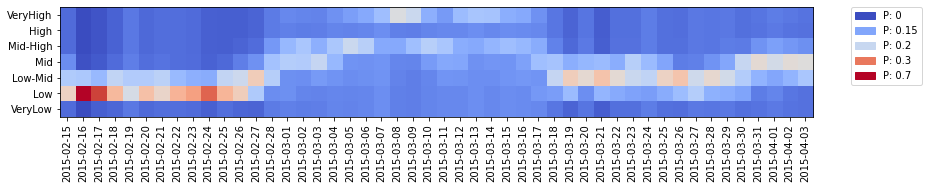

In [103]:

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

import matplotlib.patches as mpatches

fig = plt.figure(figsize=(13,30))
ax = plt.subplot2grid((1,1),(0,0))
im = plt.imshow(np.array(group.T.sort_index(ascending=False)),cmap='coolwarm')

# We want to show all ticiiks...
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
# ... and label them with the respective list entries
ax.set_xticklabels(x)
ax.set_yticklabels(y)

values = np.unique(np.array(group.T).ravel())
values = [0,0.15,0.2,0.3,0.7]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="P: {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.xticks(rotation=90)

# plt.subplots_adjust(left=0.1, bottom=1000, right=0.6, top=10000)
plt.tight_layout()

plt.savefig('pam.png', bbox_inches = "tight")

plt.show()


In [97]:
x

['2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2']

In [21]:
for index,row in df_test.iterrows():
    plt.hist(row)
    
    

NameError: name 'df_test' is not defined

# Defining times of interest


In [ ]:
# # Create an empty dictionary to have a look at how the resulting probabilties varied through time
# resulting_probs_dict = {}

# for time,model_dict['lagoon'] in model_dicts_through_time_dict.items():
    
#     #Create an empty dictionary of evidence for now
#     evidence_dict = {}
    
#     # Add evidence to model dict
#     model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)

#     # Set evidence and get beliefs
#     model_location_dict = BNModel().update_evidence(model_location_dict)
    
#     # Get the resulting TWL probabilities (right now for a generic location)
#     resulting_probs = model_location_dict['variables']['TWL']['resulting_probs']
    
#     # Add the resulting probabilities to a dictionary
#     resulting_probs_dict.update({
#         time:resulting_probs[0]
#     })

In [ ]:
# resulting_probs_dict

# Interactive Plots

In [ ]:
# # load in the reef and shoreline profile information
# df_ocean_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_outer_reef_xyxy_processed.txt')
# df_lagoon_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_inner_lagoon_xyxy.txt',delim_whitespace=True,header=None)
# df_lagoon_profiles.columns = ['reef_long','reef_lat','shore_long','shore_lat','reef_depth']


In [ ]:
# def bin_locator(value,bin_edges):
#     '''
#     function used for determining the index of the appropriate bin for a numerical value.
#     '''
#     i=0
#     for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
#         if (value>edge_1)&(value<=edge_2):
#             loc_bin = i
#         else:
#             i+=1
#             continue

#     if value<=bin_edges[0]:
#         loc_bin = 0

#     if value>=bin_edges[-1]:
#         loc_bin = len(bin_edges)-2

#     return(loc_bin)

# def model_location(model_dict,location_details,evidence_dict,variable_list):
    
#     '''
#     function for adding the location information for one side model to the evidence dictionary
#     '''
    
#     for variable in variable_list:

#         bin_edges = model_dict['variables'][variable]['bin_edges'][0]
#         value = location_details[variable]

#         var_bin = bin_locator(value,bin_edges)
        
#         evidence_array = [0]*(len(bin_edges)-1)
#         evidence_array[var_bin] = 1
        
#         evidence_dict.update({
#             variable:evidence_array
#         })

#     # Add evidence to model dict
#     model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)
    
#     # Set evidence and get beliefs
#     model_location_dict = BNModel().update_evidence(model_location_dict)
    
#     return(model_location_dict)

# def location_probabilities(evidence_dict,model_dict,variable_list,df_profiles):
#     '''
    
#     Function for setting evidence and determing probabilties for twl at each point around the island based 
#     on the reef characteristics at each location
    
#     '''
    
#     location_probabilities_dict = {}
# #     figure_dict = {}
    
#     for index,row in df_profiles.iterrows():

#         model_location_dict = model_location(model_dict,row,evidence_dict,variable_list)
#         location_probabilities = model_location_dict['variables']['TWL']['resulting_probs'][0]

#         df_location_probabilities = pd.DataFrame.from_dict(location_probabilities,orient='index')
        
# #         # Create figure for popup
# #         fig = plt.figure(figsize=(2,2))
# #         plt.bar(x=df_location_probabilities.index,height=df_location_probabilities[0])
# #         plt.savefig('{}_{}.png'.format(int(row.reef_long*1000),int(row.reef_lat*1000)))
# #         plt.close()
        
#         largest_cat = df_location_probabilities.idxmax()[0]

#         location_probabilities_dict.update({
#             (row.reef_long,row.reef_lat):\
#                 model_dict['variables']['TWL']['discretisation']['bin_names'].index(largest_cat)
#         })
        
# #         figure_dict.update({
# #             (row.reef_long,row.reef_lat):fig#html_graph
# #         })
        
#     return(location_probabilities_dict)

# def data2geojson(df):
#     features = []
#     insert_features = lambda X: features.append(
#             geojson.Feature(geometry=geojson.Point((X["long"],
#                                                     X["lat"])),
#                             properties=dict(name=X["most_likely_twl"])))
#     df.apply(insert_features, axis=1)
        
#     return(geojson.FeatureCollection(features))

# # Load SLR Projections
# data_location = "/src/Dataset/D7_MSL_projections/"
# file_name = "distributions_dict"
# with open("{}{}.json".format(data_location,file_name), 'r') as fp:
#     SL_proj_dict = json.load(fp)
    
# def SLR_proj_extractor(SL_proj_dict,AIS_config,rcp,year):
#     '''
#     Function for getting SLR projections for a given Antarctic icesheet, rcp and year
#     Years start as 2020 and go up in lots of 10 until 2150 (2100 for dp16)
#     '''
#     SLR_prob_dict = SL_proj_dict["('{}', '{}', {})".format(AIS_config,rcp,year)]
#     SLR_median_prob = np.max([float(x) for x in list(SLR_prob_dict.keys())])
#     SLR_median_MSL = float(SLR_prob_dict[str(SLR_median_prob)])/1000 #units is m

#     return(SLR_median_MSL)

In [ ]:
# def test_figure(
#     view,tide_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin,proj_time,time
#     ):
#     # Extract the right model from the dictionary of model
#     lagoon_model_dict = model_dicts_through_time_dict[time]['lagoon']
#     ocean_model_dict = model_dicts_through_time_dict[time]['ocean']
    
#     ########### get the MSL bin based on slider value
#     msl_proj = SLR_proj_extractor(SL_proj_dict,'k14','26','{}'.format(proj_time))
# #     ocean_model_dict['variables']['MSL']['bin_edges'][0]
#     bin_count = bin_locator(msl_proj,ocean_model_dict['variables']['MSL']['bin_edges'][0])
#     msl_bin = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'][bin_count]
    
#     if view == 'Map':
#         map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
#     elif view == 'Satellite':
#         token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
#         tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

#         map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
#     twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['TWL']['bin_edges'][0]]
#     twl_bins = ocean_model_dict['variables']['TWL']['discretisation']['bin_names']

#     colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
#     colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
#     ################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     ocean_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = ocean_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in ocean_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         ocean_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(ocean_evidence_dict,ocean_model_dict,variable_list,df_ocean_profiles)
    
#     # Create dataframe to plot
#     df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_ocean = data2geojson(df_twl_locations)
    
#     colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     lagoon_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         lagoon_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = []
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
#     # Create dataframe to plot
#     df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_lagoon = data2geojson(df_twl_locations)
    
#     colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     features_list = data_ocean['features']+data_lagoon['features']
    
#     data = data_ocean
#     data.update({
#         'features':features_list
#     })
    
#     colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
#     #####################################################################

#     for feature,color in zip(features_list,colors_hex_points):
#         feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
#         long,lat = feature['geometry']['coordinates']
        
#         marker = folium.CircleMarker([lat,long],color=color,
#                                     # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
#                                    fill_color=color,fill=True,fill_opacity='1',radius=5)
#         marker.add_to(map_osm)
        
#     twl_bin_edge_labels = ['{} to {} m'.format(
#         x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
#     output_list = []
#     for rgb_color in colours_rgb:
#         output = plt.scatter([],[],color=rgb_color)
#         output_list.append(output)
        
#     legend = plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly',fontsize=10)
#     plt.setp(legend.get_title(),fontsize=12)
    
#     plt.axis('off')
#     plt.savefig('legend.png')
    
#     plt.close()
    
#     url = (
#         "legend.png"
#     )    
    
#     FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
#     map_osm.save('test.html')
        
#     return(map_osm)

# # compile the figure
# lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()
# tide_bins = ocean_model_dict['variables']['Tide']['discretisation']['bin_names']
# wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']
# wave_period_bin = ocean_model_dict['variables']['Tm_offshore']['discretisation']['bin_names']
# wave_direction_bin = ocean_model_dict['variables']['Dir_offshore']['discretisation']['bin_names']
# wind_u_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# wind_v_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# time = list(model_dicts_through_time_dict.keys())  

# # Create the plot with the widget
# map_osm = interact_manual(test_figure,
#                 view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
#                 tide_bin = widgets.Dropdown(options=tide_bins,value='Mid',description='Tide',disabled=False),
#                 wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False),
#                 wave_period_bin = widgets.Dropdown(options=wave_period_bin,value='Mid',description='Wave period',disabled=False),
#                 wave_direction_bin = widgets.Dropdown(options=wave_direction_bin,value='NNE',description='Wave direction',disabled=False),
#                 wind_u_bin = widgets.Dropdown(options=wind_u_bin,value='Mid',description='Wind u',disabled=False),
#                 wind_v_bin = widgets.Dropdown(options=wind_v_bin,value='Mid',description='Wind v',disabled=False),
#                 proj_time = widgets.IntSlider(min=2020,max=2150,step=10,value=2020,description='SLR prediction'),
#                 time = widgets.Dropdown(options=time,value=727930.0,description='Time',disabled=False)
#                )

# map_osm